In [13]:
%matplotlib inline
import dbutils
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import date
from time import mktime
import calendar
import time
import numpy as np
from IPython.display import display
import random
import math
from PIL import Image
from tqdm import tqdm, trange
from IPython.display import display


measure_keys = ["height", "weight", "age", "muac", "head_circumference"]

main_connector = dbutils.connect_to_main_database()


Found 7028 scans for STD factor None.
Found 6927 scans for STD factor 2.0.
Found 6872 scans for STD factor 1.5.
Found 5741 scans for STD factor 1.0.
Found 4150 scans for STD factor 0.75.


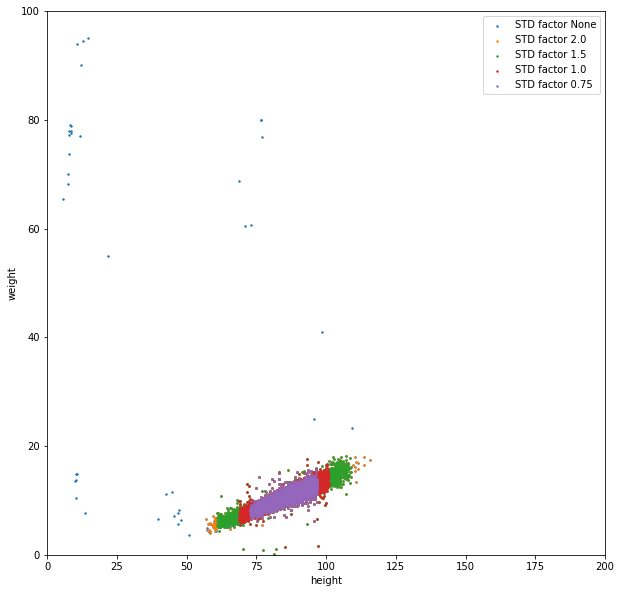

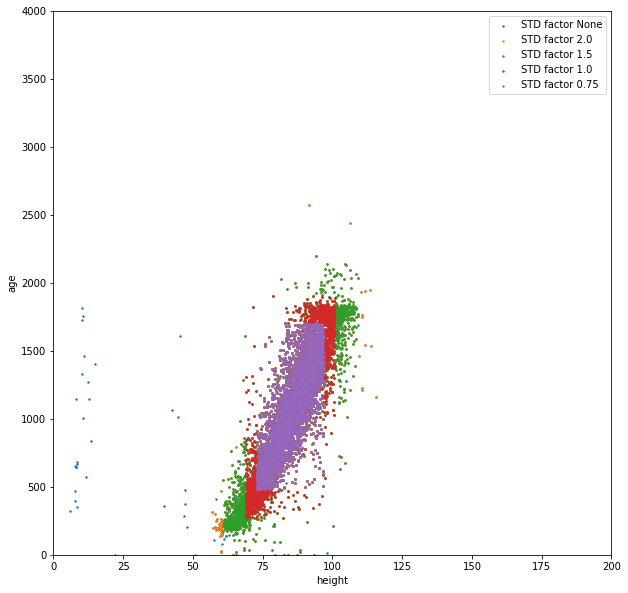

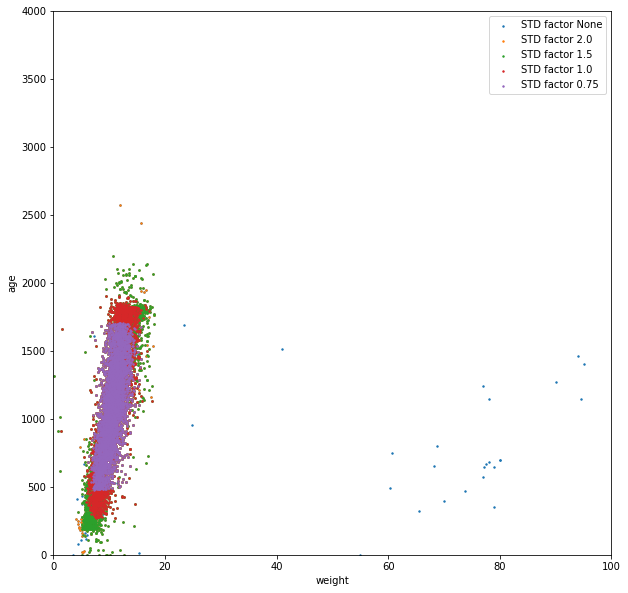

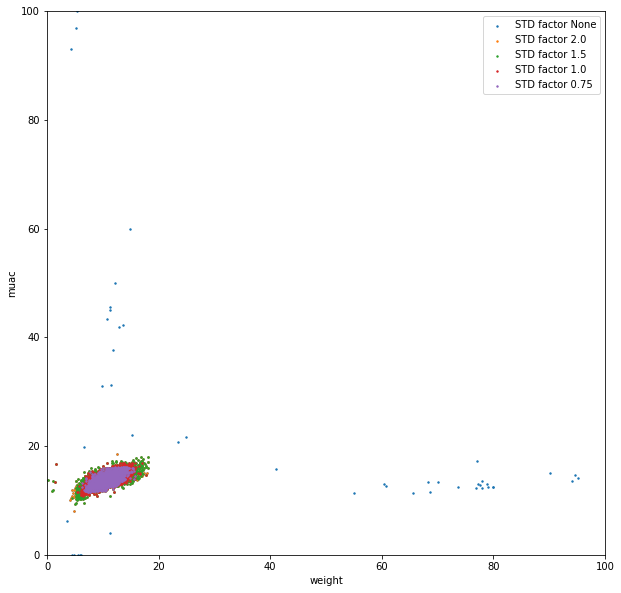

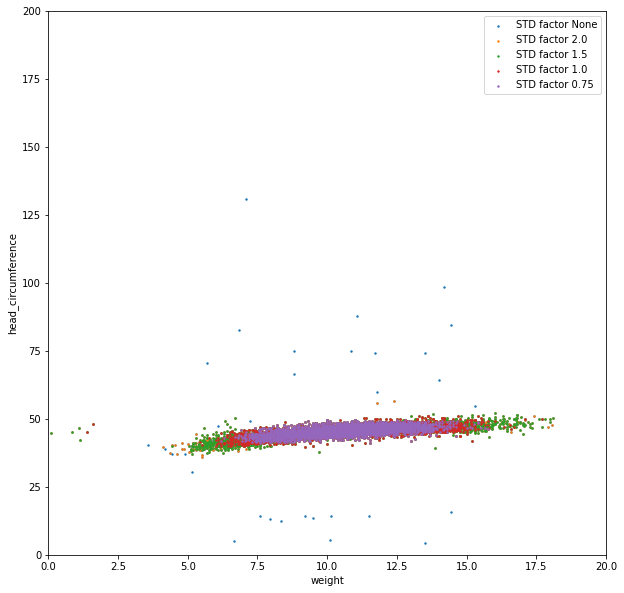

In [2]:
def select_measures_in_std_range(std_factor=None):

    sql_statement = ""
    
    # Create temporary table for average and STD.
    if std_factor != None:
        sql_statement += "WITH AvgStd AS (" + "\n"
        sql_statement += "  SELECT" + "\n"
        fields = []
        for key in measure_keys:
            fields.append("AVG({}) AS {}_avg".format(key, key))
            fields.append("STDDEV({}) AS {}_stddev".format(key, key))
        sql_statement += "    " + ",\n    ".join(fields) + "\n"
        sql_statement += "  FROM measure WHERE type='manual'" + "\n"
        sql_statement += ")" + "\n"

    # Select all fields.
    fields = ["qr_code", "measure.timestamp"]
    fields.extend(measure_keys)
    fields = ", ".join(fields)
    sql_statement += "SELECT {} FROM measure".format(fields) + "\n"
    sql_statement += " INNER JOIN person ON measure.person_id = person.id" + "\n"
    
    # Use temporary table.
    if std_factor != None:
        sql_statement += " CROSS JOIN AvgStd" + "\n"
    
    # Allow only manual measurements.
    sql_statement += " WHERE type='manual'" + "\n"
    
    # Filter my mean and STD.
    if std_factor != None:
        for key in measure_keys:
            sql_statement += " AND ABS({} - {}_avg) / {}_stddev < {}".format(key, key, key, std_factor) + "\n"

    # Done.
    sql_statement += ";"

    #print(sql_statement)

    # Retrieve all scans from database.
    #print("Getting all scans...")
    results = main_connector.execute(sql_statement, fetch_all=True)
    results = np.array(results)
    print("Found {} scans for STD factor {}.".format(len(results), std_factor))
    return results
    #print(results)

# Select measures with multiple STD ranges.
overall_results = []
for std_factor in [None, 2.0, 1.5, 1.0, 0.75]:
    results = select_measures_in_std_range(std_factor=std_factor)
    overall_results.append((std_factor, results))
    
# For rendering a scatterplot.
def render_for_keys(key1, key2, xlim, ylim):

    # Indices of the keys.
    index1 = measure_keys.index(key1)
    index2 = measure_keys.index(key2)

    # Prepare plot.
    plt.figure(figsize=(10, 10))
    plt.xlabel(key1)
    plt.ylabel(key2)
    plt.xlim(xlim)
    plt.ylim(ylim)

    # Render.
    for std_factor, all_scans in overall_results:
        # QR-codes and timestamp.
        all_scans_head = all_scans[:,:2]

        # Actual measurements. All numbers.
        all_scans_tail = all_scans[:,2:].astype("float32")

        # Render.
        plt.scatter(all_scans_tail[:,index1], all_scans_tail[:,index2], s=2, label="STD factor {}".format(std_factor))

    # Done.
    plt.legend()
    plt.show()
    plt.close()

# Render all.
render_parameters = []
render_parameters.append(("height", "weight", (0, 200), (0, 100)))
render_parameters.append(("height", "age", (0, 200), (0, 4000)))
render_parameters.append(("weight", "age", (0, 100), (0, 4000)))
render_parameters.append(("weight", "muac", (0, 100), (0, 100)))
render_parameters.append(("weight", "head_circumference", (0, 20), (0,200)))
for key1, key2, xlim, ylim in render_parameters:
    render_for_keys(key1, key2, xlim, ylim)

In [3]:
# Get all scans.
all_scans = select_measures_in_std_range(std_factor=2.0)

# QR-codes and timestamp.
all_scans_head = all_scans[:,:2]

# Actual measurements. All numbers.
all_scans_tail = all_scans[:,2:].astype("float32")

Found 6927 scans for STD factor 2.0.


# Interactive cell for accepting/rejecting scans.

Selecting artifacts...
RJ_WHH_2543 1547713443732
Found 4150 JPGs for QR-code RJ_WHH_2543 and timestamp 1547713443732.
Rendering artifacts...


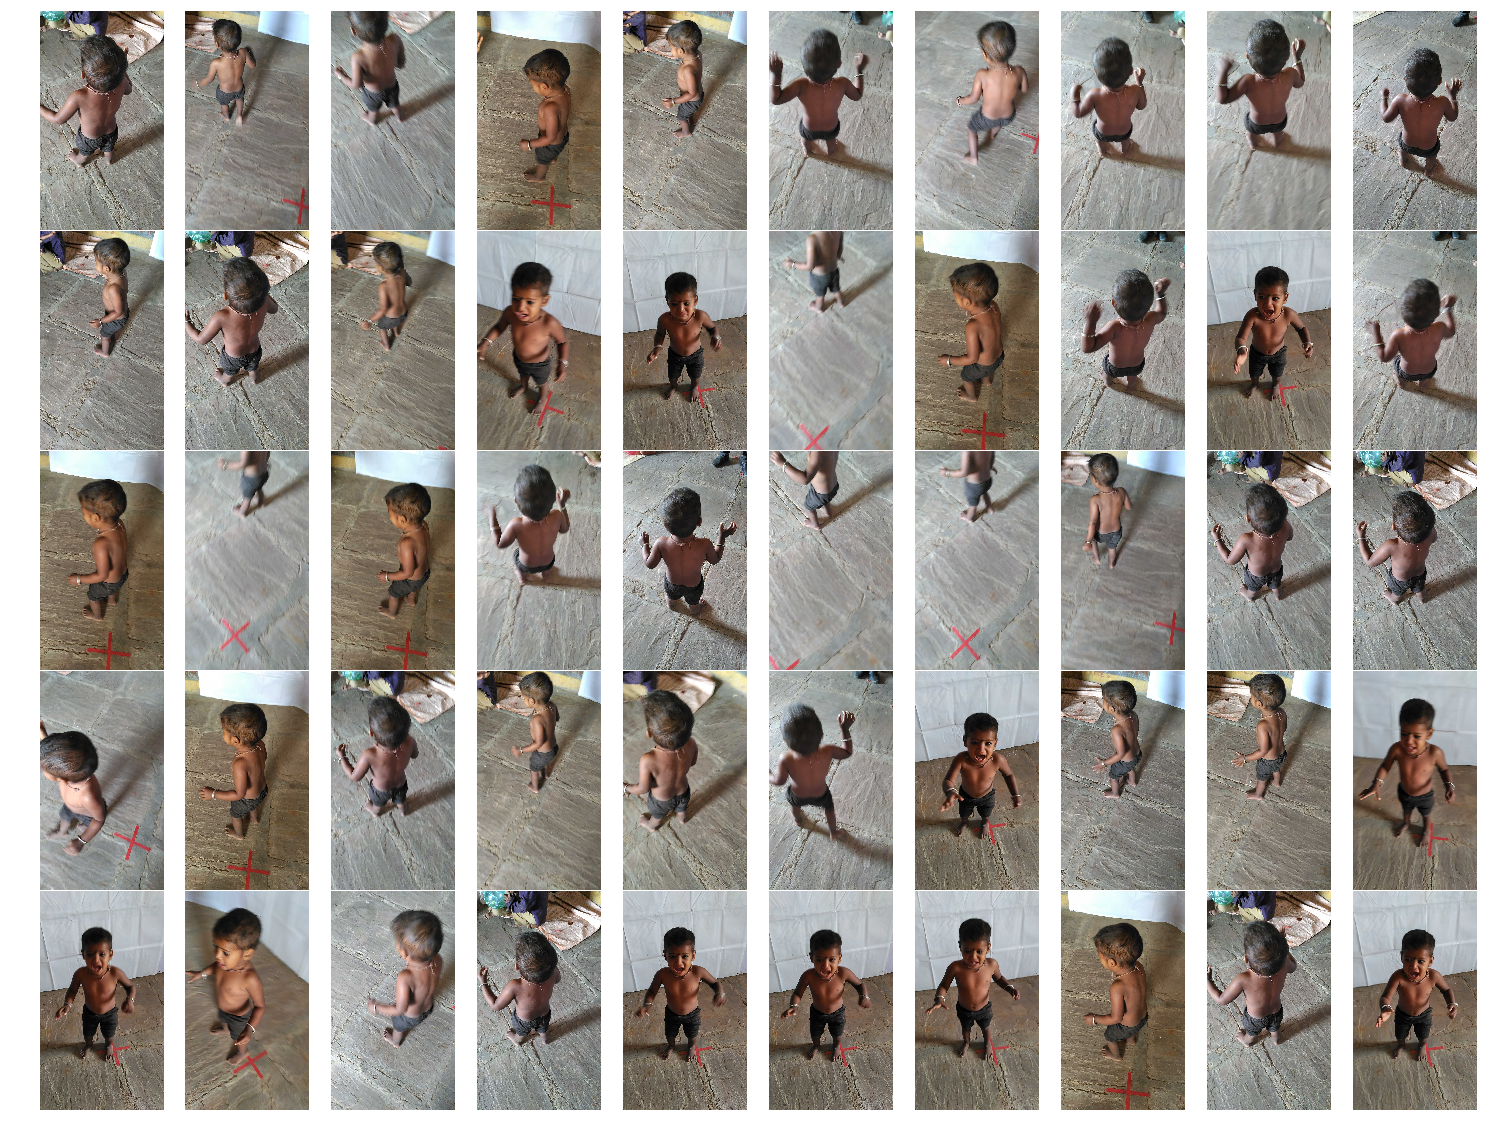

Selecting artifacts...
RJ_WHH_1864 1546929477483
MP_WHH_1522 1544082767554
Found 4150 JPGs for QR-code MP_WHH_1522 and timestamp 1544082767554.
191 191
Rendering artifacts...


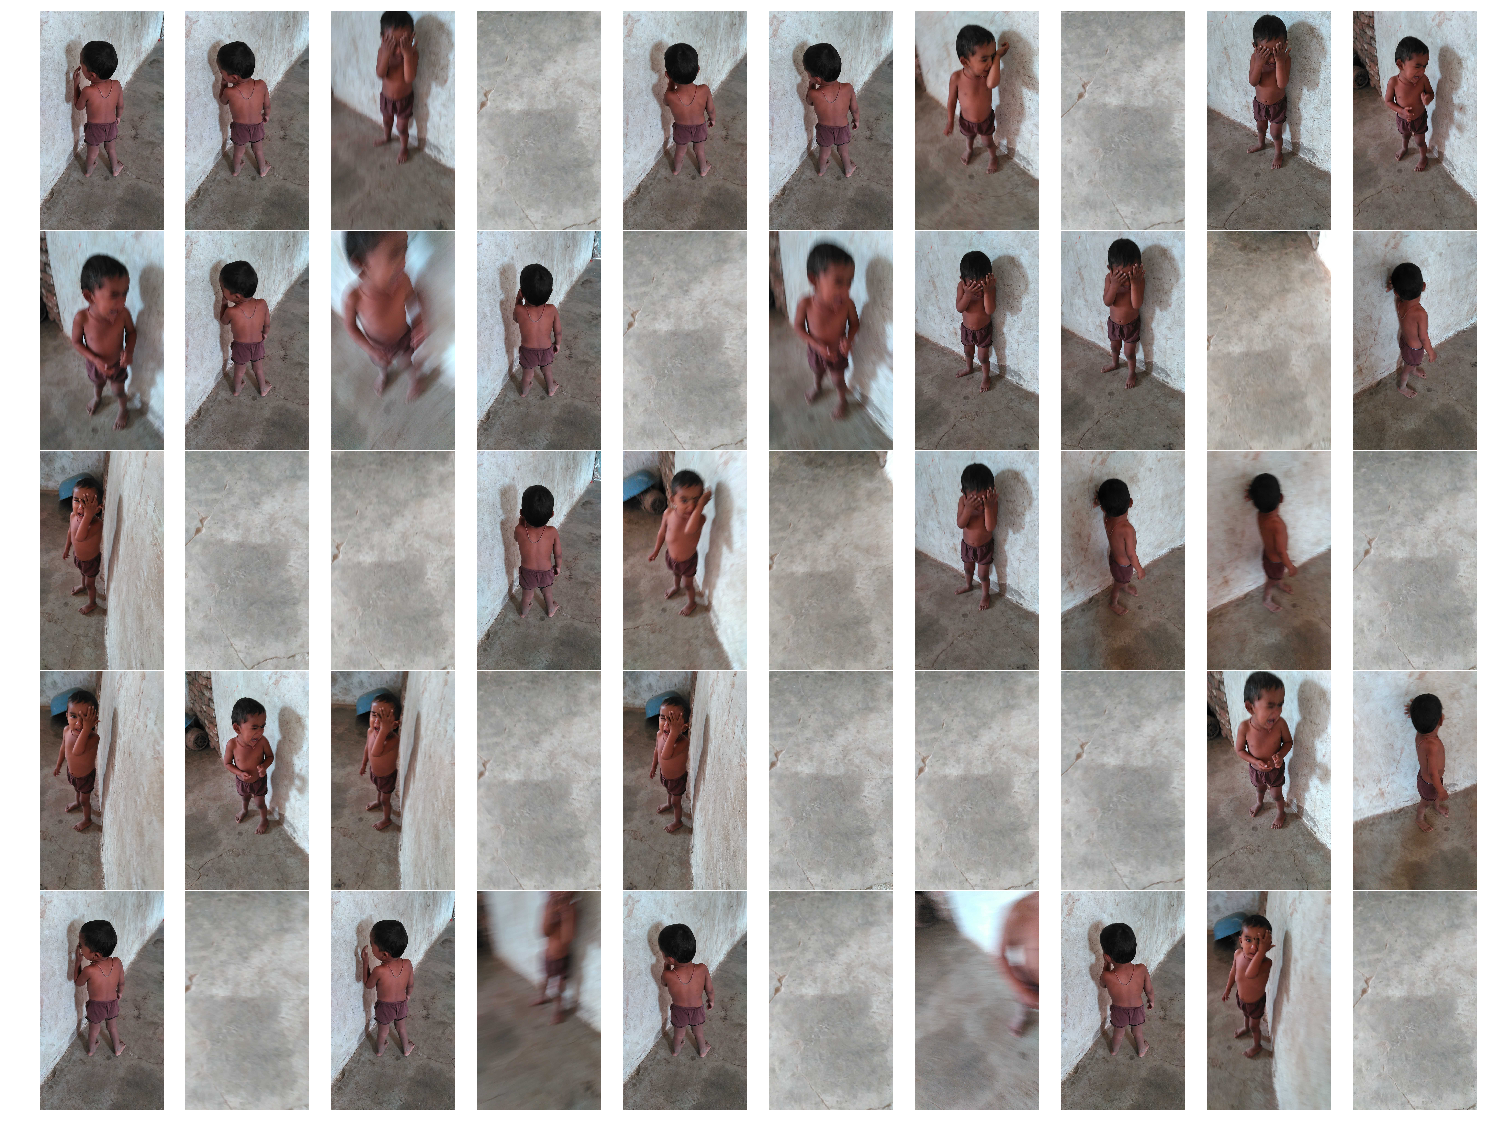

In [32]:
import ipywidgets as widgets
from ipywidgets import HBox, Output
from IPython.display import display, clear_output

# Runs the whole thing.
def clear_and_display():
    clear_output()
    artifacts, qr_code, timestamp = select_artifacts()
    render_artifacts(artifacts, qr_code, timestamp, 10)
    display(HBox([accept_button, reject_button]))
    
# Select a random thingy.
def select_artifacts():
    print("Selecting artifacts...")
    artifacts = []
    while len(artifacts) ==  0:
        index = random.randint(0, len(all_scans))
        qr_code, timestamp = all_scans_head[index]

        # Select all JPGs for that.
        def select_jpgs(qr_code, timestamp):
            print(qr_code, timestamp)
            sql_statement = ""
            sql_statement += "SELECT path FROM artifact AS a "
            sql_statement += " INNER JOIN measure AS m ON m.id=a.measure_id"
            sql_statement += " INNER JOIN person AS P ON p.id=m.person_id"
            sql_statement += " WHERE p.qr_code='{}'".format(qr_code)
            sql_statement += " AND m.timestamp='{}'".format(timestamp)
            sql_statement += " AND a.type='rgb'".format(timestamp)
            sql_statement += ";"

            results = main_connector.execute(sql_statement, fetch_all=True)
            results = np.array(results)
            return results
        artifacts = select_jpgs(qr_code, timestamp)
    print("Found {} JPGs for QR-code {} and timestamp {}.".format(len(results), qr_code, timestamp))
    return artifacts, qr_code, timestamp


# Render a subsample of the artifacts.
def render_artifacts(artifacts, qr_code, timestamp, num_columns=10, num_rows=5):
    print("Rendering artifacts...")
    
    # Take a random subsample.
    indices = list(range(len(artifacts)))
    random.shuffle(indices)
    indices = indices[:num_columns * num_rows]
    artifacts = artifacts[indices]

    # Render subplots.
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 15))
    axes = axes.reshape(-1)
    for path, axis in zip(artifacts, axes):
        path = path[0]
        path = path.replace("whhdata", "localssd")
        img = Image.open(path)
        img = np.array(img)
        img = np.rot90(img, 3)
        axis.axis("off")
        axis.imshow(img)
    fig.tight_layout(pad=-2, w_pad=-2, h_pad=-2)
    plt.show()
    plt.close()


# Accept button.
accept_button = widgets.Button(description="Accept")
def on_accept_button_clicked(_):
    clear_and_display()
    
accept_button.on_click(on_accept_button_clicked)

# Accept button.
reject_button = widgets.Button(description="Reject")
def on_reject_button_clicked(_):
    clear_and_display()
    do_it()
reject_button.on_click(on_reject_button_clicked)

# Initial render.
clear_and_display()

In [ ]:
# TODO DB interaction
# TODO count pointclouds of accepted measures
# TODO create measure_quality table